Import libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
from google.colab import drive
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import time
from torchvision import transforms, utils
import matplotlib.pyplot as plt

# specific package for visualization
!pip install livelossplot --quiet
from livelossplot import PlotLosses

# get the device type of machine
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Utils

In [2]:
def count_parameters(model):
  """Function for count model's parameters"""
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

Mount the google drive

In [4]:
# Jacob
drive.mount('/content/drive')
% cd 'drive/My Drive/Colab Notebooks/247_data/project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/247_data/project


In [3]:
# tim
drive.mount('/content/drive')
% cd 'drive/My Drive/Colab Notebooks/ECE C247 group project/project_data/project/'

Mounted at /content/drive
[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/ECE C247 group project/project_data/project/'
/content


In [ ]:
## yang
#drive.mount('/content/drive')
#%cp /content/drive/MyDrive/c247proj/project_data.zip .
#!unzip project_data.zip
#%cd project

Mounted at /content/drive
Archive:  project_data.zip
   creating: project/
  inflating: project/EEG_loading.ipynb  
   creating: __MACOSX/
   creating: __MACOSX/project/
  inflating: __MACOSX/project/._EEG_loading.ipynb  
  inflating: project/X_train_valid.npy  
  inflating: __MACOSX/project/._X_train_valid.npy  
  inflating: project/.DS_Store       
  inflating: __MACOSX/project/._.DS_Store  
  inflating: project/person_train_valid.npy  
  inflating: __MACOSX/project/._person_train_valid.npy  
  inflating: project/y_train_valid.npy  
  inflating: __MACOSX/project/._y_train_valid.npy  
  inflating: project/y_test.npy      
  inflating: __MACOSX/project/._y_test.npy  
  inflating: project/X_test.npy      
  inflating: __MACOSX/project/._X_test.npy  
   creating: project/.ipynb_checkpoints/
  inflating: project/.ipynb_checkpoints/EEG_loading-checkpoint.ipynb  
   creating: __MACOSX/project/.ipynb_checkpoints/
  inflating: __MACOSX/project/.ipynb_checkpoints/._EEG_loading-checkpoint.ipynb

# 1. load data

## 1.1 helper functions

In [5]:
class EEGDataset(Dataset):
    """EEG dataset."""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
          pass 
            # x = self.transform(x)
            # y = self.transform(y)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [6]:
def make_steps(samples,samples_per_frame,stride):
    '''
    in:
    samples - number of samples in the session
    samples_per_frame - number of samples in the frame
    stride - the gap between succesive frames
    out: list of tuple ranges
    '''
    
    i = 0
    intervals = []
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + stride
    return intervals

def make_win_data_pipeline(data_arr,label_arr,num_samples_frame,stride):
    '''
    in:
    data_arr - original data array without windowing
    label_arr - labels of the data array without windowing
    num_samples_frame - number of samples in the frame
    stride - the gap between succesive frames
    
    out:
    data_win_arr - windowed data array
    label_win_arr - labels of the windowed data array
    
    '''
    
    num_trials = data_arr.shape[0]
    num_channels = data_arr.shape[1]
    num_samples = data_arr.shape[2]
    
    steps_list = make_steps(num_samples,num_samples_frame,stride)
    num_windows = len(steps_list)
    
    data_win_arr = np.zeros((num_trials*num_windows,num_channels,num_samples_frame))
    label_win_arr = []
    k = 0
    
    for i in range(num_trials):
        
        trial_label = label_arr[i]
        trial_data = data_arr[i,:,:]
        
        for m,n in enumerate(steps_list):
            start_ind = n[0]
            end_ind = n[1]
            
            win_data = trial_data[:,start_ind:end_ind]
            data_win_arr[k,:,:] = win_data
            label_win_arr.append(trial_label)
            k = k+1
    
    label_win_arr = np.asarray(label_win_arr)
    return data_win_arr, label_win_arr

### 1.2 load data from np files

In [7]:
# loading data from files as np array
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_train_valid = np.load("person_train_valid.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_test = np.load("person_test.npy")

# adjust labels 
y_train_valid -= 769
y_test -= 769

In [8]:
# show the dimensions of the np array
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


## 1.3 generated windowed data






In [9]:
# create windowed tensor

# Preparing the training and validation data
num_samples_frame = 500
stride = 100
X_train_win,y_train_win = make_win_data_pipeline(X_train_valid,y_train_valid,num_samples_frame,stride)
X_test_win,y_test_win = make_win_data_pipeline(X_test,y_test,num_samples_frame,stride)

print ('Windowed Training/Valid data shape: {}'.format(X_train_win.shape))
print ('Windowed Training/Valid label shape: {}'.format(y_train_win.shape))
print ('Windowed Test data shape: {}'.format(X_test_win.shape))
print ('Windowed Test label shape: {}'.format(y_test_win.shape))

Windowed Training/Valid data shape: (12690, 22, 500)
Windowed Training/Valid label shape: (12690,)
Windowed Test data shape: (2658, 22, 500)
Windowed Test label shape: (2658,)


## 1.4 generate subject data

In [10]:
X_train_valid_subs = [X_train_valid[np.where(person_train_valid == i)[0]] for i in range(9)]
y_train_valid_subs = [y_train_valid[np.where(person_train_valid == i)[0]] for i in range(9)]
X_test_subs = [X_test[np.where(person_test == i)[0]] for i in range(9)]
y_test_subs = [y_test[np.where(person_test == i)[0]] for i in range(9)]
'''
for i in range(0,9):
  print(person_train_valid[person_train_valid == i].shape[0])
  print(X_train_valid_subs[i].shape[0])
  print(y_train_valid_subs[i].shape[0])

for i in range(0,9):
  print(person_test[person_test == i].shape[0])
  print(X_test_subs[i].shape[0])
  print(y_test_subs[i].shape[0])
'''

'\nfor i in range(0,9):\n  print(person_train_valid[person_train_valid == i].shape[0])\n  print(X_train_valid_subs[i].shape[0])\n  print(y_train_valid_subs[i].shape[0])\n\nfor i in range(0,9):\n  print(person_test[person_test == i].shape[0])\n  print(X_test_subs[i].shape[0])\n  print(y_test_subs[i].shape[0])\n'

## 1.5 create tensor from numpy


for original data

In [11]:
# copy numpy data to tensor for orignal data
X_train_valid_tensor = torch.from_numpy(X_train_valid).float().to(device)
y_train_valid_tensor = torch.from_numpy(y_train_valid).float().long().to(device) # do not forget .long()
X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().long().to(device) # do not forget .long()

print ('Training/Valid tensor shape: {}'.format(X_train_valid_tensor.shape))
print ('Training/Valid target tensor shape: {}'.format(y_train_valid_tensor.shape))
print ('Test tensor shape: {}'.format(X_test_tensor.shape))
print ('Test target tensor shape: {}'.format(y_test_tensor.shape))

Training/Valid tensor shape: torch.Size([2115, 22, 1000])
Training/Valid target tensor shape: torch.Size([2115])
Test tensor shape: torch.Size([443, 22, 1000])
Test target tensor shape: torch.Size([443])


for windowed data

In [12]:
# Converting the numpy data to torch tensors for windowed data
X_train_valid_win_tensor = torch.from_numpy(X_train_win).float().to(device)
y_train_valid_win_tensor = torch.from_numpy(y_train_win).float().long().to(device) 

# Preparing the test dataset
X_test_win_tensor = torch.from_numpy(X_test_win).float().to(device)
y_test_win_tensor = torch.from_numpy(y_test_win).float().long().to(device) 
    
print ('Training/Valid tensor shape: {}'.format(X_train_valid_win_tensor.shape))
print ('Training/Valid target tensor shape: {}'.format(y_train_valid_win_tensor.shape))
print ('Test tensor shape: {}'.format(X_test_win_tensor.shape))
print ('Test target tensor shape: {}'.format(y_test_win_tensor.shape))

Training/Valid tensor shape: torch.Size([12690, 22, 500])
Training/Valid target tensor shape: torch.Size([12690])
Test tensor shape: torch.Size([2658, 22, 500])
Test target tensor shape: torch.Size([2658])




for data of each subject

In [13]:
X_train_valid_tensor_subs = [torch.from_numpy(X_train_valid_subs[i]).float().to(device) for i in range(9)]
y_train_valid_tensor_subs = [torch.from_numpy(y_train_valid_subs[i]).float().long().to(device) for i in range(9)] 
X_test_tensor_subs = [torch.from_numpy(X_test_subs[i]).float().to(device) for i in range(9)]
y_test_tensor_subs = [torch.from_numpy(y_test_subs[i]).float().long().to(device) for i in range(9)] 

## 1.6 create dataloaders

dataloader for original data

In [14]:
# create dataloader for orignal data

init_dataset = TensorDataset(X_train_valid_tensor, y_train_valid_tensor) 
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# split train and val
lengths = [int(len(init_dataset)*0.8), int(len(init_dataset)*0.2)] 
subset_train, subset_val = random_split(init_dataset, lengths) 

train_data = EEGDataset(
    subset_train, transform=None)

val_data = EEGDataset(
    subset_val, transform=None)

# create dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=False, num_workers=0)
}
 
test_data = EEGDataset(test_dataset, transform=None)

dataloader for data of each subject

In [15]:
dataloaders_subs = []
test_data_subs = []
for i in range(9):
  # create dataloader for orignal data

  init_dataset = TensorDataset(X_train_valid_tensor_subs[i], y_train_valid_tensor_subs[i]) 
  test_dataset = TensorDataset(X_test_tensor_subs[i], y_test_tensor_subs[i])

  # split train and val
  lengths = [int(len(init_dataset)*0.8), len(init_dataset) - int(len(init_dataset)*0.8)] 
  subset_train, subset_val = random_split(init_dataset, lengths) 

  train_data = EEGDataset(
      subset_train, transform=None)

  val_data = EEGDataset(
      subset_val, transform=None)

  # create dataloaders
  dataloaders_subs.append({
      'train': torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0),
      'val': torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=False, num_workers=0)
  })
  
  test_data_subs.append(EEGDataset(test_dataset, transform=None))

dataloader for windowed data

In [16]:
# create dataloader for windowed data

win_dataset = TensorDataset(X_train_valid_win_tensor, y_train_valid_win_tensor) 
test_win_dataset = TensorDataset(X_test_win_tensor, y_test_win_tensor)

# Spliting the dataset into training and validation

lengths = [int(len(win_dataset)*0.8), int(len(win_dataset)*0.2)] 
subset_win_train, subset_win_val = random_split(win_dataset, lengths) 

train_win_data = EEGDataset(subset_win_train, transform=None)
val_win_data = EEGDataset(subset_win_val, transform=None)

# Constructing the training and validation dataloaders and test dataloader

win_dataloaders = {
    'train': torch.utils.data.DataLoader(train_win_data, batch_size=32, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(val_win_data, batch_size=8, shuffle=False, num_workers=0)
}

test_win_data = EEGDataset(test_win_dataset, transform=None)

#2. Training and Testing script



In [17]:
def train_model(model, optimizer, num_epochs, dataloaders):
    # for each epoch... 
    liveloss = PlotLosses()

    best_valid_loss = float('inf')
    for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      logs = {}

      # let every epoch go through one training cycle and one validation cycle
      # TRAINING AND THEN VALIDATION LOOP...
      for phase in ['train', 'val']:
        train_loss = 0
        correct = 0
        total = 0
        batch_idx = 0

        start_time = time.time()
        # first loop is training, second loop through is validation
        # this conditional section picks out either a train mode or validation mode
        # depending on where we are in the overall training process
        # SELECT PROPER MODE- train or val
        if phase == 'train':
          for param_group in optimizer.param_groups:
            print("LR", param_group['lr']) # print out the learning rate
          model.train()  # Set model to training mode
        else:
          model.eval()   # Set model to evaluate mode
        
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)
          batch_idx += 1
          
          optimizer.zero_grad()
          
          with torch.set_grad_enabled(phase == 'train'):
          #    the above line says to disable gradient tracking for validation
          #    which makes sense since the model is in evluation mode and we 
          #    don't want to track gradients for validation)
            outputs = model(inputs)
            # compute loss where the loss function will be defined later
            
            loss = loss_fn(outputs, labels)
            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()
            train_loss += loss
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # if phase == 'train':
        #   if  epoch%5 == 0:
        #   # prints for training and then validation (since the network will be in either train or eval mode at this point) 
        #     print(" Training Epoch %d, Total loss %0.6f, iteration time %0.6f" % (epoch, train_loss, time.time() - start_time))

        # if phase == 'val' and epoch%5 == 0:
        #   print(" Validation Epoch %d, Total loss %0.6f, iteration time %0.6f" % (epoch, train_loss, time.time() - start_time))


        prefix = ''
        cur_loss = train_loss.item()/(batch_idx)

        if phase == 'val':
            prefix = 'val_'

            if cur_loss < best_valid_loss:
                best_valid_loss = cur_loss
                torch.save(model.state_dict(), 'best_model.pt')
        
        logs[prefix + 'loss'] = cur_loss
        logs[prefix + 'acc'] = correct/total*100.

      liveloss.update(logs)
      liveloss.send()

    # end of single epoch iteration... repeat of n epochs  
    return model

In [18]:
def test_model(model,test_data,criterion):
    
    
    # Creating the test dataloader
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True, num_workers=0)
    
    # Making the predictions on the dataset
    
    total_test_preds = 0
    correct_test_preds = 0
    test_loss = 0
    
    model.eval()
    with torch.no_grad():
        
        for test_inputs, test_labels in test_dataloader:
            
            # Transfer test data and labels to device
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.to(device)
            
            # Perform forward pass
            test_outputs = model(test_inputs)
            
            # Compute loss
            test_loss = criterion(test_outputs,test_labels)
            
            # Compute test statistics
                    
            test_loss += test_loss.item()
            _, test_predicted = test_outputs.max(1)
            total_test_preds += test_labels.size(0)
            correct_test_preds += test_predicted.eq(test_labels).sum().item()
            
        test_acc = correct_test_preds/total_test_preds
        print('Test loss', test_loss)
        print('Test accuracy',test_acc*100)
        
    
    return test_acc

#3. Models

## 3.1 Baseline model

In [117]:
class ShallowConv(nn.Module):
  def __init__(self, in_channels, classes):
    super(ShallowConv, self).__init__()
    # Define the conv layer, https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    self.conv1 = nn.Conv2d(in_channels, 40, (1, 25), stride=1)
    # Define the fc layer, https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
    self.fc1 = nn.Linear(880, 40)
    self.avgpool = nn.AvgPool1d(75, stride=15)
    self.fc2 = nn.Linear(2440, classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = x.view(-1, 1, 22, 1000) # reshape x: (B, 22, 1000) -> (B, 1, 22, 1000), B,C,H,W
    x = self.conv1(x) # (B, 40, 22, 976)
    x = x.permute(0, 3, 1, 2) # (B, 976, 22, 40)
    x = x.view(-1, 976, 880) 
    x = self.fc1(x) # (-1, 976, 40)
    x = torch.square(x) # square act
    x = x.permute(0, 2, 1) # (-1, 40, 976)
    x = self.avgpool(x) # (-1, 40, 61)
    x = torch.log(x) # log act
    x = x.reshape(-1, 40*61)
    x = self.fc2(x)
    x = self.softmax(x) # softmax before the output

    return x 


## 3.2 baseline CNN for windowed data

In [ ]:
# Defining the shallow conv net
class ShallowConv2(nn.Module):
    
    # Defining the building blocks of shallow conv net
    
    def __init__(self, in_channels, num_conv_filters, num_samples_frame, num_eeg_channels,classes):
    
        # Defining as a subclass
        super(ShallowConv2, self).__init__()

        self.num_samples_frame = num_samples_frame
        self.num_conv_filters = num_conv_filters
        self.num_eeg_channels = num_eeg_channels
        
        # Define the convolution layer, https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(in_channels, self.num_conv_filters, (1, 25), stride=1)
        self.conv_output_width =  int(self.num_samples_frame - (25-1) - 1 + 1)
        
        # Define the 2d batchnorm layer
        self.bnorm2d = nn.BatchNorm2d(self.num_conv_filters)
        
        # Define the 1d batchnorm layer
        self.bnorm1d = nn.BatchNorm1d(self.num_conv_filters)


        # Define the fc layer, https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.fc1 = nn.Linear(self.num_eeg_channels*self.num_conv_filters, self.num_conv_filters)
        
        # Define the elu activation
        self.elu = nn.ELU(0.2)

        # Define the avg pooling layer
        self.avgpool = nn.AvgPool1d(75, stride=15)
        
        self.num_features_linear = int(np.floor(((self.conv_output_width - 75)/15)+1))
        
        

        # Define the fc layer for generating the scores for classes 
        self.fc2 = nn.Linear(self.num_features_linear*self.num_conv_filters, classes)

        # Define the softmax layer for converting the class scores to probabilities
        self.softmax = nn.Softmax(dim=1)
        
    # Defining the connections of shallow conv net
    
    def forward(self, x):
        
        # Reshaping the input for 2-D convolution (B,22,num_samples_frame) -> (B,1,22,num_samples_frame)
        
        x = x.view(-1, 1, 22, self.num_samples_frame)
        
        # Performing the 2-D convolution (B,1,22,300) -> (B,40,22,x_shape_4dim)
        
        x = self.conv1(x)
        x_shape_4dim = x.shape[3]
        
        # ELU activation
        
        x = self.elu(x)
        
        # 2d Batch normalization
        
        x = self.bnorm2d(x)
        
        
        # Reshaping the input to dense layer (B,40,22,x_shape_4dim) -> (B,x_shape_4dim,880)
        
        x = x.permute(0,3,1,2) # (B,40,22,x_shape_4dim) -> (B,x_shape_4dim,40,22)
        x = x.view(-1,x_shape_4dim,880)
        
        # Passing through the dense layer (B,x_shape_4dim,880) -> (B,x_shape_4dim,40)
        
        x = self.fc1(x)
        
        # ELU activation
        
        x = self.elu(x)
        
        # Square activation
        
        x = torch.square(x)
        
        # Reshaping the input for average pooling layer (B,x_shape_4dim,40) -> (B,40,x_shape_4dim)
        
        x = x.permute(0,2,1)
        
        # Passing through the average pooling layer (B,40,x_shape_4dim) -> (B,40,x_pool_3dim)
        
        x = self.avgpool(x)
        x_pool_3dim = x.shape[2]
        
        # Log activation
        
        x = torch.log(x)
        
        # 1D Batch normalization
        
        x = self.bnorm1d(x)
        #print(x.shape)
        
        # Reshaping the input to dense layer (B,40,x_pool_3dim) -> (B,40*x_pool_3dim)
        
        x = x.reshape(-1, 40*x_pool_3dim)
        
        # Passing through the dense layer (B,40*x_pool_3dim) -> (B,classes)
        
        x = self.fc2(x)
        
        # Passing through the softmax layer
        
        x = self.softmax(x)
        
        return x

## 3.3 RNN model

In [ ]:
class RNNModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout=0.0):
    super(RNNModel, self).__init__()

    # Hidden dimensions
    self.hidden_dim = hidden_dim
    # Number of hidden layers
    self.layer_dim = layer_dim

    # rnn layer
    self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu', dropout=dropout)
    # output layer
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    x = x.permute(0,2,1) # (B, 1000, 22)
    x, _ = self.rnn(x, self.init_hidden(x.size(0))) # (B, 1000, 64)
    x = self.fc(x[:, -1, :]) # (B, 4)
    return x

  def init_hidden(self, batch_size):
    return torch.zeros(self.layer_dim, batch_size, self.hidden_dim).to(device)

## 3.4 LSTM model

In [ ]:
class LSTMModel(nn.Module):

  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout=0.0):
    super(LSTMModel, self).__init__()

    # Hidden dimensions
    self.hidden_dim = hidden_dim
    # Number of hidden layers
    self.layer_dim = layer_dim

    # LSTM layer
    self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, dropout=dropout, batch_first=True) # batch_first=True causes input/output tensors to be of shape (batch_dim, seq_dim, input_dim)
    # output layer
    self.fc = nn.Linear(hidden_dim, output_dim)
    
  def forward(self, x):
    x = x.permute(0,2,1) # (B, 1000, 22)
    x, _ = self.lstm(x, self.init_hidden(x.size(0))) # (B, 1000, 64)
    x = self.fc(x[:, -1, :]) # (B, 4)
    return x
  
  def init_hidden(self, batch_size):
    return (torch.zeros(self.layer_dim, batch_size, self.hidden_dim).to(device), torch.zeros(self.layer_dim, batch_size, self.hidden_dim).to(device))

##3.5 GRU Model

In [ ]:
class GRUModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout=0.0):
    super(GRUModel, self).__init__()

    # Hidden dimensions
    self.hidden_dim = hidden_dim
    # Number of hidden layers
    self.layer_dim = layer_dim

    # GRU layer
    self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout)
    # output layer
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    x = x.permute(0,2,1) # (B, 1000, 22)
    x, _ = self.gru(x, self.init_hidden(x.size(0))) # (B, 1000, 64)
    x = self.fc(x[:, -1, :]) # (B, 4)
    return x

  def init_hidden(self, batch_size):
    return torch.zeros(self.layer_dim, batch_size, self.hidden_dim).to(device)

## 3.6 CRNN model

Original CRNN

In [ ]:
# 这个model别改
class CRNN_v1(nn.Module):
  def __init__(self, in_channels, classes):
    super(CRNN_v1, self).__init__()

    # Define the first conv layer
    self.conv1 = nn.Conv2d(in_channels, 16, (1, 10))
    # define the ELU activation layer
    self.elu = nn.ELU()
    # define the first batch normalization layer
    self.bn1 = nn.BatchNorm2d(16)
    # define the seoncd conv layer
    self.conv2 = nn.Conv2d(16, 32, (21, 1))
    # define the second batch normalization layer
    self.bn2 = nn.BatchNorm2d(32)
    # define the maxpool layer
    self.maxpool = nn.MaxPool2d((1,4))
    # define the third conv layer
    self.conv3 = nn.Conv2d(32, 64, (1, 10))
    # define the third batch normalization layer
    self.bn3 = nn.BatchNorm2d(64)
    # define the fourth conv layer
    self.conv4 = nn.Conv2d(64, 128, (1, 10))
    # define the fourth batch normalization layer
    self.bn4 = nn.BatchNorm2d(128)
    # define the dropout lauer
    self.dropout = nn.Dropout(0.4)
    # define the first LSTM layer
    self.lstm1 = nn.LSTM(256, 128, 1, batch_first=True, bidirectional=True)
    # define the second LSTM layer
    self.lstm2 = nn.LSTM(256, 64, 1, batch_first=True, bidirectional=True)
    # define the third LSTM layer
    self.lstm3 = nn.LSTM(128, 32, 1, batch_first=True, bidirectional=True)
    # define the fully-connected layer
    self.fc = nn.Linear(64, classes)

  def init_hidden(self, batch_size, hidden_dim, layer_dim = 1):
    return (torch.zeros(layer_dim*2, batch_size, hidden_dim).to(device), torch.zeros(layer_dim*2, batch_size, hidden_dim).to(device))

  def forward(self, x): # (B, 22, 1000)
    x = x.view(-1, 1, 22, 1000) # (B, 1, 22, 1000)

    x = self.conv1(x) # (B, 16, 22, 991)
    x = self.elu(x) # (B, 16, 22, 991)
    x = self.bn1(x) # (B, 16, 22, 991)

    x = self.conv2(x) # (B, 32, 2, 991)
    x = self.elu(x) # (B, 32, 2, 991)
    x = self.bn2(x) # (B, 32, 2, 991) 
    x = self.maxpool(x) # (B, 32, 2, 247)

    x = self.conv3(x) # (B, 64, 2, 238)
    x = self.elu(x) # (B, 64, 2, 238)
    x = self.bn3(x) # (B, 64, 2, 238)
    x = self.maxpool(x) # (B, 64, 2, 59)
    
    x = self.conv4(x) # (B, 128, 2, 50)
    x = self.elu(x) # (B, 128, 2, 50)
    x = self.bn4(x) # (B, 128, 2, 50)
    x = self.maxpool(x) # (B, 128, 2, 12)
    x = self.dropout(x) # (B, 128, 2, 12)

    x = x.permute(0, 3, 1, 2) # (B, 12, 128, 2)
    x = x.view(-1, 12, 256) # (B, 12, 256) 
    x, _ = self.lstm1(x, self.init_hidden(x.shape[0],128)) # (B, 12, 128)
    x, _ = self.lstm2(x, self.init_hidden(x.shape[0],64)) # (B, 12, 64)
    x, _ = self.lstm3(x, self.init_hidden(x.shape[0],32)) # (B, 12, 32)
    x = self.dropout(x) # (B, 12, 32)
    
    x = self.fc(x[:,-1,:]) # (B, 4) orignal
    return x 


CRNN model (modified)

In [ ]:
# 这个model别改
class CRNN_v2(nn.Module):
  def __init__(self, in_channels, classes):
    super(CRNN_v2, self).__init__()

    # Define the first conv layer
    self.conv1 = nn.Conv2d(in_channels, 16, (1, 10))
    # define the ELU activation layer
    self.elu = nn.ELU()
    # define the first batch normalization layer
    self.bn1 = nn.BatchNorm2d(16)
    # define the seoncd conv layer
    self.conv2 = nn.Conv2d(16, 32, (21, 1))
    # define the second batch normalization layer
    self.bn2 = nn.BatchNorm2d(32)
    # define the maxpool layer
    self.maxpool = nn.MaxPool2d((1,4))
    # define the third conv layer
    self.conv3 = nn.Conv2d(32, 64, (1, 10))
    # define the third batch normalization layer
    self.bn3 = nn.BatchNorm2d(64)
    # define the fourth conv layer
    self.conv4 = nn.Conv2d(64, 128, (1, 10))
    # define the fourth batch normalization layer
    self.bn4 = nn.BatchNorm2d(128)
    # define the dropout lauer
    self.dropout = nn.Dropout(0.4)
    # define the first LSTM layer
    self.lstm1 = nn.LSTM(256, 128, 1, batch_first=True, bidirectional=True)
    # define the second LSTM layer
    self.lstm2 = nn.LSTM(256, 64, 1, batch_first=True, bidirectional=True)
    # define the third LSTM layer
    self.lstm3 = nn.LSTM(128, 32, 1, batch_first=True, bidirectional=True)
    # define the fully-connected layer
    #self.fc = nn.Linear(64, classes)
    self.fc1 = nn.Linear(64, 16)
    self.fc2 = nn.Linear(16, classes)

  def init_hidden(self, batch_size, hidden_dim, layer_dim = 1):
    return (torch.zeros(layer_dim*2, batch_size, hidden_dim).to(device), torch.zeros(layer_dim*2, batch_size, hidden_dim).to(device))

  def forward(self, x): # (B, 22, 1000)
    x = x.view(-1, 1, 22, 1000) # (B, 1, 22, 1000)

    x = self.conv1(x) # (B, 16, 22, 991)
    x = self.elu(x) # (B, 16, 22, 991)
    x = self.bn1(x) # (B, 16, 22, 991)

    x = self.conv2(x) # (B, 32, 2, 991)
    x = self.elu(x) # (B, 32, 2, 991)
    x = self.bn2(x) # (B, 32, 2, 991) 
    x = self.maxpool(x) # (B, 32, 2, 247)

    x = self.conv3(x) # (B, 64, 2, 238)
    x = self.elu(x) # (B, 64, 2, 238)
    x = self.bn3(x) # (B, 64, 2, 238)
    x = self.maxpool(x) # (B, 64, 2, 59)
    x = self.dropout(x) # (B, 64, 2, 59) added
    
    x = self.conv4(x) # (B, 128, 2, 50)
    x = self.elu(x) # (B, 128, 2, 50)
    x = self.bn4(x) # (B, 128, 2, 50)
    x = self.maxpool(x) # (B, 128, 2, 12)
    x = self.dropout(x) # (B, 128, 2, 12)

    x = x.permute(0, 3, 1, 2) # (B, 12, 128, 2)
    x = x.view(-1, 12, 256) # (B, 12, 256) 
    x, _ = self.lstm1(x, self.init_hidden(x.shape[0],128)) # (B, 12, 128)
    x, _ = self.lstm2(x, self.init_hidden(x.shape[0],64)) # (B, 12, 64)
    x, _ = self.lstm3(x, self.init_hidden(x.shape[0],32)) # (B, 12, 32)
    x = self.dropout(x) # (B, 12, 32)
    
    #x = self.fc(x[:,-1,:]) # (B, 4) orignal
    x = self.fc1(x[:,-1,:])# (B, 16) added
    x = self.elu(x) # (B, 16) added
    x = self.fc2(x) # (B, 4) added
    return x 


CRNN with GRU

In [ ]:
# 这个model别改
class CRNN_v4(nn.Module):
  def __init__(self, in_channels, classes):
    super(CRNN_v4, self).__init__()

    # Define the first conv layer
    self.conv1 = nn.Conv2d(in_channels, 16, (1, 10))
    # define the ELU activation layer
    self.elu = nn.ELU()
    # define the first batch normalization layer
    self.bn1 = nn.BatchNorm2d(16)
    # define the seoncd conv layer
    self.conv2 = nn.Conv2d(16, 32, (21, 1))
    # define the second batch normalization layer
    self.bn2 = nn.BatchNorm2d(32)
    # define the maxpool layer
    self.maxpool = nn.MaxPool2d((1,4))
    # define the third conv layer
    self.conv3 = nn.Conv2d(32, 64, (1, 10))
    # define the third batch normalization layer
    self.bn3 = nn.BatchNorm2d(64)
    # define the fourth conv layer
    self.conv4 = nn.Conv2d(64, 128, (1, 10))
    # define the fourth batch normalization layer
    self.bn4 = nn.BatchNorm2d(128)
    # define the dropout layer
    self.dropout = nn.Dropout(0.4)
    # define the first GRU layer
    self.gru1 = nn.GRU(256, 128, 1, batch_first=True, bidirectional=True)
    # define the second GRU layer
    self.gru2 = nn.GRU(256, 64, 1, batch_first=True, bidirectional=True)
    # define the third GRU layer
    self.gru3 = nn.GRU(128, 32, 1, batch_first=True, bidirectional=True)
    # define the fully-connected layer
    #self.fc = nn.Linear(64, classes)
    self.fc1 = nn.Linear(64, 16)
    self.fc2 = nn.Linear(16, classes)

  def init_hidden(self, batch_size, hidden_dim, layer_dim = 1):
    return torch.zeros(layer_dim*2, batch_size, hidden_dim).to(device)

  def forward(self, x): # (B, 22, 1000)
    x = x.view(-1, 1, 22, 1000) # (B, 1, 22, 1000)

    x = self.conv1(x) # (B, 16, 22, 991)
    x = self.elu(x) # (B, 16, 22, 991)
    x = self.bn1(x) # (B, 16, 22, 991)

    x = self.conv2(x) # (B, 32, 2, 991)
    x = self.elu(x) # (B, 32, 2, 991)
    x = self.bn2(x) # (B, 32, 2, 991) 
    x = self.maxpool(x) # (B, 32, 2, 247)

    x = self.conv3(x) # (B, 64, 2, 238)
    x = self.elu(x) # (B, 64, 2, 238)
    x = self.bn3(x) # (B, 64, 2, 238)
    x = self.maxpool(x) # (B, 64, 2, 59)
    x = self.dropout(x) # (B, 64, 2, 59) added
    
    x = self.conv4(x) # (B, 128, 2, 50)
    x = self.elu(x) # (B, 128, 2, 50)
    x = self.bn4(x) # (B, 128, 2, 50)
    x = self.maxpool(x) # (B, 128, 2, 12)
    x = self.dropout(x) # (B, 128, 2, 12)

    x = x.permute(0, 3, 1, 2) # (B, 12, 128, 2)
    x = x.view(-1, 12, 256) # (B, 12, 256) 
    x, _ = self.gru1(x, self.init_hidden(x.shape[0],128)) # (B, 12, 256)
    x, _ = self.gru2(x, self.init_hidden(x.shape[0],64)) # (B, 12, 128)
    x, _ = self.gru3(x, self.init_hidden(x.shape[0],32)) # (B, 12, 64)
    x = self.dropout(x) # (B, 12, 64)
    
    #x = self.fc(x[:,-1,:]) # (B, 4) orignal
    x = self.fc1(x[:,-1,:])# (B, 16) added
    x = self.elu(x) # (B, 16) added
    x = self.fc2(x) # (B, 4) added
    return x 


CRNN 3 layers of CNN and FC+GRU

In [ ]:
class CRNN_v5(nn.Module):
  def __init__(self, in_channels, classes):
    super(CRNN_v5, self).__init__()

    # Define the first conv layer
    self.conv1 = nn.Conv2d(in_channels, 16, (1, 10))
    # define the ELU activation layer
    self.elu = nn.ELU()
    # define the first batch normalization layer
    self.bn1 = nn.BatchNorm2d(16)
    # define the seoncd conv layer
    self.conv2 = nn.Conv2d(16, 32, (21, 1))
    # define the second batch normalization layer
    self.bn2 = nn.BatchNorm2d(32)
    # define the maxpool layer
    self.maxpool = nn.MaxPool2d((1,4))
    # define the third conv layer
    self.conv3 = nn.Conv2d(32, 64, (1, 10))
    # define the third batch normalization layer
    self.bn3 = nn.BatchNorm2d(64)
    # define the dropout layer
    self.dropout = nn.Dropout(0.4)
    # define the fully-connected layer
    self.fc1 = nn.Linear(13 * 128, 64)
    # define the first GRU layer
    self.gru = nn.GRU(1, 16, 1, batch_first=True, bidirectional=True)
    # define the fully-connected layer
    self.fc2 = nn.Linear(32, classes)

  def init_hidden(self, batch_size, hidden_dim, layer_dim = 1):
    return torch.zeros(layer_dim*2, batch_size, hidden_dim).to(device)

  def forward(self, x): # (B, 22, 1000)
    x = x.view(-1, 1, 22, 1000) # (B, 1, 22, 1000)

    x = self.conv1(x) # (B, 16, 22, 991)
    x = self.elu(x) # (B, 16, 22, 991)
    x = self.bn1(x) # (B, 16, 22, 991)
    x = self.maxpool(x) # (B, 16, 22, 247)
    
    x = self.conv2(x) # (B, 32, 2, 247)
    x = self.elu(x) # (B, 32, 2, 247)
    x = self.bn2(x) # (B, 32, 2, 247) 
    x = self.maxpool(x) # (B, 32, 2, 61)
    x = self.dropout(x) # (B, 32, 2, 61)
    
    x = self.conv3(x) # (B, 64, 2, 52)
    x = self.elu(x) # (B, 64, 2, 52)
    x = self.bn3(x) # (B, 64, 2, 52)
    x = self.maxpool(x) # (B, 64, 2, 13)
    x = self.dropout(x) # (B, 64, 2, 13)
    
    #x = x.permute(0, 3, 1, 2) # (B, 13, 64, 2)
    x = x.reshape(-1, 13 * 128) # (B, 13 * 128) 
    x = self.fc1(x) # (B, 64)
    x = x.view(-1, 64, 1) # (B, 64, 1)

    x, _ = self.gru(x, self.init_hidden(x.shape[0],16)) # (B, 64, 32)
    x = self.fc2(x[:,-1,:]) # (B, 4) added
    return x 


###new

In [ ]:
# 这个model别改
class CRNN_v6(nn.Module):
  def __init__(self, in_channels, classes):
    super(CRNN_v6, self).__init__()

    # Define the first conv layer
    self.conv1 = nn.Conv2d(in_channels, 16, (1, 10))
    # define the ELU activation layer
    self.elu = nn.ELU()
    # define the first batch normalization layer
    self.bn1 = nn.BatchNorm2d(16)
    # define the seoncd conv layer
    self.conv2 = nn.Conv2d(16, 32, (21, 1))
    # define the second batch normalization layer
    self.bn2 = nn.BatchNorm2d(32)
    # define the maxpool layer
    self.maxpool = nn.MaxPool2d((1,4))
    # define the third conv layer
    self.conv3 = nn.Conv2d(32, 64, (1, 10))
    # define the third batch normalization layer
    self.bn3 = nn.BatchNorm2d(64)
    # define the fourth conv layer
    self.conv4 = nn.Conv2d(64, 128, (1, 10))
    # define the fourth batch normalization layer
    self.bn4 = nn.BatchNorm2d(128)
    # define the dropout layer
    self.dropout = nn.Dropout(0.4)

    # define the third GRU layer
    self.gru = nn.GRU(1, 32, 1, batch_first=True, bidirectional=True)
    # define the fully-connected layer
    self.fc1 = nn.Linear(12*256, 32)
    self.fc2 = nn.Linear(64, 16)
    self.fc3 = nn.Linear(16, classes)

  def init_hidden(self, batch_size, hidden_dim, layer_dim = 1):
    return torch.zeros(layer_dim*2, batch_size, hidden_dim).to(device)

  def forward(self, x): # (B, 22, 1000)
    x = x.view(-1, 1, 22, 1000) # (B, 1, 22, 1000)

    x = self.conv1(x) # (B, 16, 22, 991)
    x = self.elu(x) # (B, 16, 22, 991)
    x = self.bn1(x) # (B, 16, 22, 991)

    x = self.conv2(x) # (B, 32, 2, 991)
    x = self.elu(x) # (B, 32, 2, 991)
    x = self.bn2(x) # (B, 32, 2, 991) 
    x = self.maxpool(x) # (B, 32, 2, 247)
    x = self.dropout(x) # (B, 64, 2, 59)

    x = self.conv3(x) # (B, 64, 2, 238)
    x = self.elu(x) # (B, 64, 2, 238)
    x = self.bn3(x) # (B, 64, 2, 238)
    x = self.maxpool(x) # (B, 64, 2, 59)
    x = self.dropout(x) # (B, 64, 2, 59)
    
    x = self.conv4(x) # (B, 128, 2, 50)
    x = self.elu(x) # (B, 128, 2, 50)
    x = self.bn4(x) # (B, 128, 2, 50)
    x = self.maxpool(x) # (B, 128, 2, 12)
    x = self.dropout(x) # (B, 128, 2, 12)

    x = x.reshape(-1, 12*256) # (B, 12*256) 
    x = self.fc1(x) # (B, 32)
    x = x.reshape(-1, 32, 1)

    x, _ = self.gru(x, self.init_hidden(x.shape[0],32)) # (B, 32, 64)
    x = self.dropout(x) # (B, 32, 64)
    
    x = self.fc2(x[:,-1,:])# (B, 16) added
    x = self.elu(x) # (B, 16) added
    x = self.fc3(x) # (B, 4) added
    return x 


In [ ]:
# 这个model别改
class CRNN_v7(nn.Module):
  def __init__(self, in_channels, classes):
    super(CRNN_v7, self).__init__()

    # Define the first conv layer
    self.conv1 = nn.Conv2d(in_channels, 16, (1, 10))
    # define the ELU activation layer
    self.elu = nn.ELU()
    # define the first batch normalization layer
    self.bn1 = nn.BatchNorm2d(16)
    # define the seoncd conv layer
    self.conv2 = nn.Conv2d(16, 32, (21, 1))
    # define the second batch normalization layer
    self.bn2 = nn.BatchNorm2d(32)
    # define the maxpool layer
    self.maxpool = nn.MaxPool2d((1,4))
    # define the third conv layer
    self.conv3 = nn.Conv2d(32, 64, (1, 10))
    # define the third batch normalization layer
    self.bn3 = nn.BatchNorm2d(64)
    # define the fourth conv layer
    self.conv4 = nn.Conv2d(64, 128, (1, 10))
    # define the fourth batch normalization layer
    self.bn4 = nn.BatchNorm2d(128)
    # define the dropout layer
    self.dropout = nn.Dropout(0.5)

    # define the third GRU layer
    self.gru = nn.GRU(1, 32, 1, batch_first=True, bidirectional=True)
    # define the fully-connected layer
    self.fc1 = nn.Linear(12*256, 32)
    self.fc2 = nn.Linear(64, 16)
    self.fc3 = nn.Linear(16, classes)

  def init_hidden(self, batch_size, hidden_dim, layer_dim = 1):
    return torch.zeros(layer_dim*2, batch_size, hidden_dim).to(device)

  def forward(self, x): # (B, 22, 1000)
    x = x.view(-1, 1, 22, 1000) # (B, 1, 22, 1000)

    x = self.conv1(x) # (B, 16, 22, 991)
    x = self.elu(x) # (B, 16, 22, 991)
    x = self.bn1(x) # (B, 16, 22, 991)

    x = self.conv2(x) # (B, 32, 2, 991)
    x = self.elu(x) # (B, 32, 2, 991)
    x = self.bn2(x) # (B, 32, 2, 991) 
    x = self.maxpool(x) # (B, 32, 2, 247)
    x = self.dropout(x) # (B, 64, 2, 59)

    x = self.conv3(x) # (B, 64, 2, 238)
    x = self.elu(x) # (B, 64, 2, 238)
    x = self.bn3(x) # (B, 64, 2, 238)
    x = self.maxpool(x) # (B, 64, 2, 59)
    x = self.dropout(x) # (B, 64, 2, 59)
    
    x = self.conv4(x) # (B, 128, 2, 50)
    x = self.elu(x) # (B, 128, 2, 50)
    x = self.bn4(x) # (B, 128, 2, 50)
    x = self.maxpool(x) # (B, 128, 2, 12)
    x = self.dropout(x) # (B, 128, 2, 12)

    x = x.reshape(-1, 12*256) # (B, 12*256) 
    x = self.fc1(x) # (B, 32)
    x = x.reshape(-1, 32, 1)

    x, _ = self.gru(x, self.init_hidden(x.shape[0],32)) # (B, 32, 64)
    x = self.dropout(x) # (B, 32, 64)
    
    x = self.fc2(x[:,-1,:])# (B, 16) added
    x = self.elu(x) # (B, 16) added
    x = self.fc3(x) # (B, 4) added
    return x 


## Deep CNN

In [ ]:
# class DeepCNN(nn.Module):
#   def __init__(self, in_channels, classes):
#     super(DeepCNN, self).__init__()

#     self.elu = nn.ELU()
#     self.maxpool = nn.MaxPool2d((1, 3), stride=(1, 3))
#     self.dropout = nn.Dropout(0.5)

#     self.conv1 = nn.Conv2d(in_channels, out_channels=25, kernel_size=(1, 10), stride=(1, 1), padding=(1, 4))
#     self.bnorm1 = nn.BatchNorm2d(25)

#     self.conv2 = nn.Conv2d(25, out_channels=50, kernel_size=(1, 10), stride=(1, 1), padding=(1, 4))
#     self.bnorm2 = nn.BatchNorm2d(50)

#     self.conv3 = nn.Conv2d(50, out_channels=100, kernel_size=(1, 10), stride=(1, 1), padding=(1, 4))
#     self.bnorm3 = nn.BatchNorm2d(100)

#     self.conv3 = nn.Conv2d(100, out_channels=200, kernel_size=(1, 10), stride=(1, 1), padding=(1, 4))
#     self.bnorm3 = nn.BatchNorm2d(200)

#     self.fc = nn.Linear(2400, classes)

#   def forward(self, x):
#     x = x.view(-1, 22, 1, 1000) 
#     x = self.conv1(x) # (-1, 25, 1, 1000)
#     x = self.elu(x)
#     x = self.maxpool(x) # (-1, 25, 1, 333)
#     x = self.bnorm1(x)
#     x = self.dropout(x)

#     x = self.conv2(x) # (-1, 50, 1, 333)
#     x = self.elu(x)
#     x = self.maxpool(x) # (-1, 50, 1, 111)
#     x = self.bnorm2(x)
#     x = self.dropout(x)

#     x = self.conv3(x) # (-1, 100, 1, 111)
#     x = self.elu(x)
#     x = self.maxpool(x) # (-1, 100, 1, 37)
#     x = self.bnorm3(x)
#     x = self.dropout(x)

#     x = self.conv4(x) # (-1, 200, 1, 37)
#     x = self.elu(x)
#     x = self.maxpool(x) # (-1, 200, 1, 12)
#     x = self.bnorm4(x)
#     x = self.dropout(x)

#     x = x.view(-1, 2400)
#     x = self.fc(x)

## 3.7 Deep ConvNet

In [137]:
class DeepConv(nn.Module):
  def __init__(self, in_channels, classes):
    super(DeepConv, self).__init__()
    ## block 1
    self.conv1 = nn.Conv2d(in_channels, 25, (1, 10), stride=1)
    self.fc1 = nn.Linear(550, 25)
    self.maxpool1 = nn.MaxPool1d(3, stride=3)
    
    ## block 2
    self.conv2 = nn.Conv2d(1,50,(25,10),stride=1)
    self.maxpool2 = nn.MaxPool1d(3,stride=3)

    ## block 3
    self.conv3 = nn.Conv2d(1,100,(50,10),stride=1)
    self.maxpool3 = nn.MaxPool1d(3,stride=3)

    ## block 4
    self.conv4 = nn.Conv2d(1,200,(100,10),stride=1)
    self.maxpool4 = nn.MaxPool1d(3,stride=3)

    ## classification
    self.fc2 = nn.Linear(1400, classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = x.view(-1, 1, 22, 1000) # reshape x: (B, 22, 1000) -> (B, 1, 22, 1000), B,C,H,W

    ## block 1
    x = self.conv1(x) # (B, 25, 22, 991)
    x = x.permute(0, 3, 1, 2) # (B, 991, 25,22)
    x = x.view(-1, 991, 550) 
    x = self.fc1(x) # (-1, 991, 25)
    x = torch.square(x) # square act
    x = x.permute(0, 2, 1) # (-1, 25, 991)
    x = self.maxpool1(x) # (B, 25, 330)

    ## block 2
    x = x.view(-1,1,25,330) # (B,1,25,330)
    x = self.conv2(x) # (B,50,1,321)
    x = x.permute(0,2,1,3) # (B,1,50,321)
    x = x.view(-1,50,321)
    x = self.maxpool2(x) #(B,50,107)

    ## block 3
    x = x.view(-1,1,50,107) # (B,1,50,107)
    x = self.conv3(x) # (B,100,1,98)
    x = x.permute(0,2,1,3) # (B,1,100,98)
    x = x.view(-1,100,98)
    x = self.maxpool3(x) #(B,100,32)

    ## block 4
    x = x.view(-1,1,100,32) # (B,1,100,32)
    x = self.conv4(x) # (B,200,1,23)
    x = x.permute(0,2,1,3) # (B,1,200,23)
    x = x.view(-1,200,23)

    x = self.maxpool4(x) #(B,1,200,7)

    # x = torch.log(x) # log act

    x = x.reshape(-1, 1400)
    x = self.fc2(x)
    x = self.softmax(x) # softmax before the output

    return x 


#4. Evaluate different models

##4.1 evaluate baseline model

In [118]:
# define the hyperparamters
weight_decay = 0.15  # weight decay to alleviate overfiting

model = ShallowConv(in_channels=1, classes=4).to(device)

count = count_parameters(model)
print ('model parameters amount {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)


model parameters amount 46044


In [119]:
#********************** TRAIN AND SAVE MODEL ******************************#
model=train_model(model, optimizer, num_epochs=250, dataloaders=dataloaders)

KeyboardInterrupt: ignored

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_a = test_model(model,test_data,loss_fn)

Test loss tensor(1.6608, device='cuda:0')
Test accuracy 69.07449209932281


##4.2 evaluate RNN

In [ ]:
# define the hyperparamters
weight_decay = 1e-3  # weight decay to alleviate overfiting

model = RNNModel(22, 64, 2, 4).to(device)

count = count_parameters(model)
print ('model parameters amountt {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=weight_decay)


model parameters amountt 14212


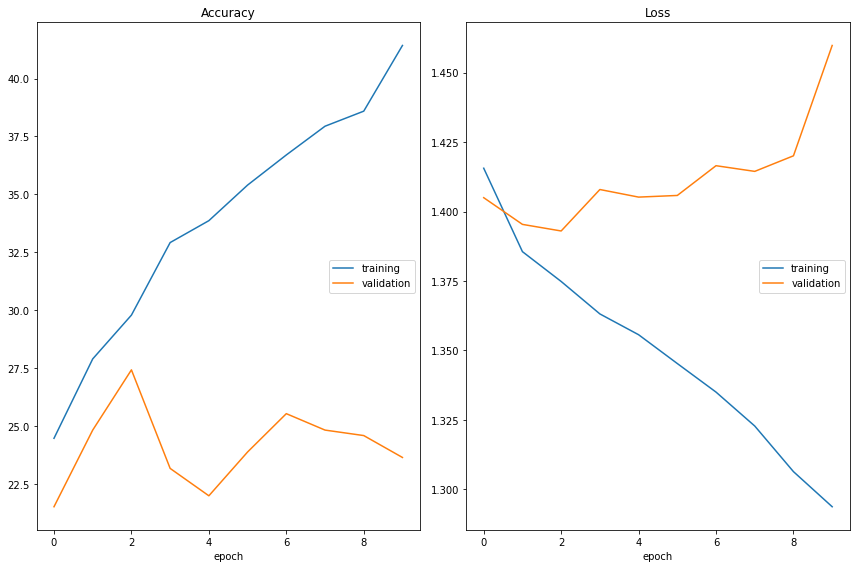

Accuracy
	training         	 (min:   24.468, max:   41.430, cur:   41.430)
	validation       	 (min:   21.513, max:   27.423, cur:   23.641)
Loss
	training         	 (min:    1.294, max:    1.416, cur:    1.294)
	validation       	 (min:    1.393, max:    1.460, cur:    1.460)


In [ ]:
#********************** TRAIN AND SAVE MODEL ******************************#
model=train_model(model, optimizer, num_epochs=10, dataloaders=dataloaders)

##4.3 evaluate LSTM

In [ ]:
# define the hyperparamters
weight_decay = 0.01  # weight decay to alleviate overfiting

model = LSTMModel(22, 64, 2, 4).to(device)

count = count_parameters(model)
print ('model parameters amount {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)


model parameters amount 56068


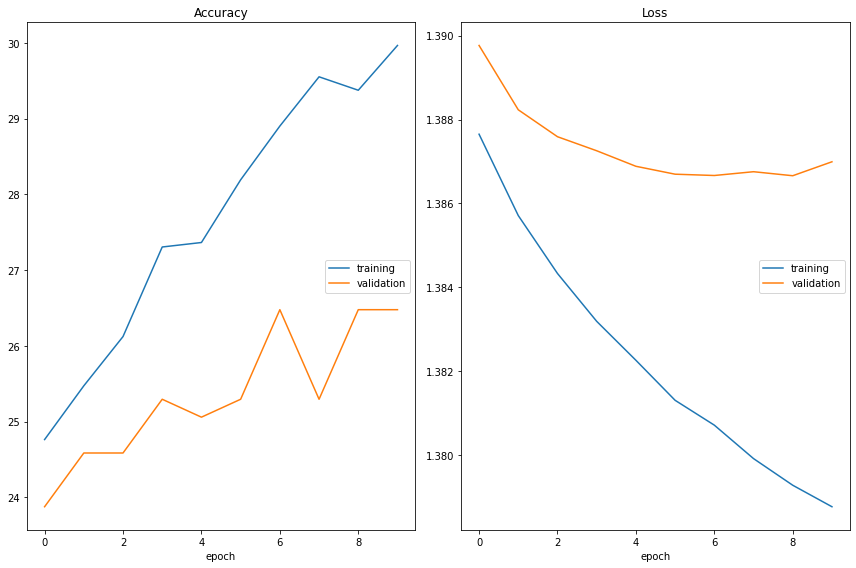

Accuracy
	training         	 (min:   24.764, max:   29.965, cur:   29.965)
	validation       	 (min:   23.877, max:   26.478, cur:   26.478)
Loss
	training         	 (min:    1.379, max:    1.388, cur:    1.379)
	validation       	 (min:    1.387, max:    1.390, cur:    1.387)


In [ ]:
#********************** TRAIN AND SAVE MODEL ******************************#
model=train_model(model, optimizer, num_epochs=10, dataloaders=dataloaders)

##4.4 evaluate GRU model

In [ ]:
# define the hyperparamters
weight_decay = 1e-3  # weight decay to alleviate overfiting

model_ = GRUModel(22, 64, 2, 4).to(device)

count = count_parameters(model_)
print ('model parameters amountt {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_.parameters(), lr = 1e-3, weight_decay=weight_decay)

model parameters amountt 42116


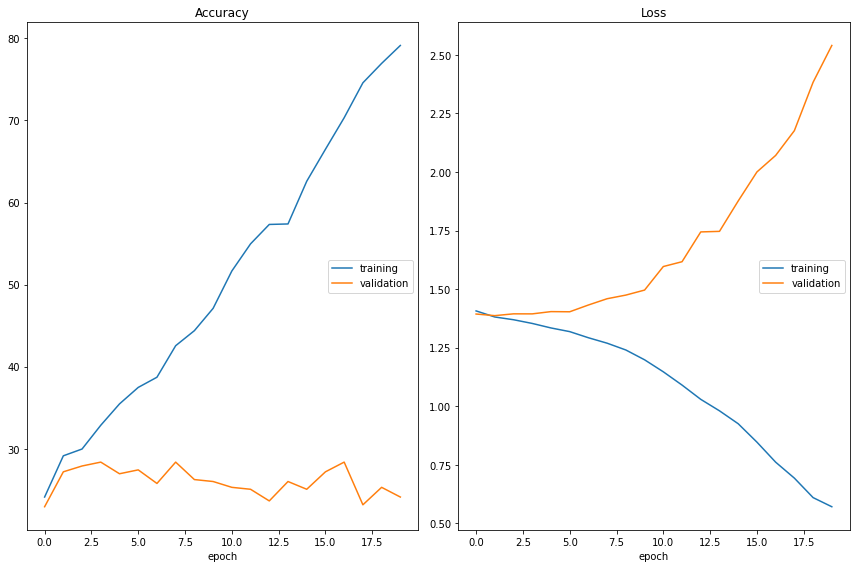

Accuracy
	training         	 (min:   24.113, max:   79.137, cur:   79.137)
	validation       	 (min:   22.931, max:   28.369, cur:   24.113)
Loss
	training         	 (min:    0.571, max:    1.407, cur:    0.571)
	validation       	 (min:    1.387, max:    2.540, cur:    2.540)


In [ ]:
#********************** TRAIN AND SAVE MODEL ******************************#
model_=train_model(model_, optimizer, num_epochs=20, dataloaders=dataloaders)

##4.5 evaluate CRNN model

train original CRNN model

In [ ]:
# define the hyperparamters
weight_decay = 0.001 # weight decay to alleviate overfiting

model = CRNN_v1(in_channels=1, classes=4).to(device)

count = count_parameters(model)
print ('model parameters amount {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)

model parameters amount 715892


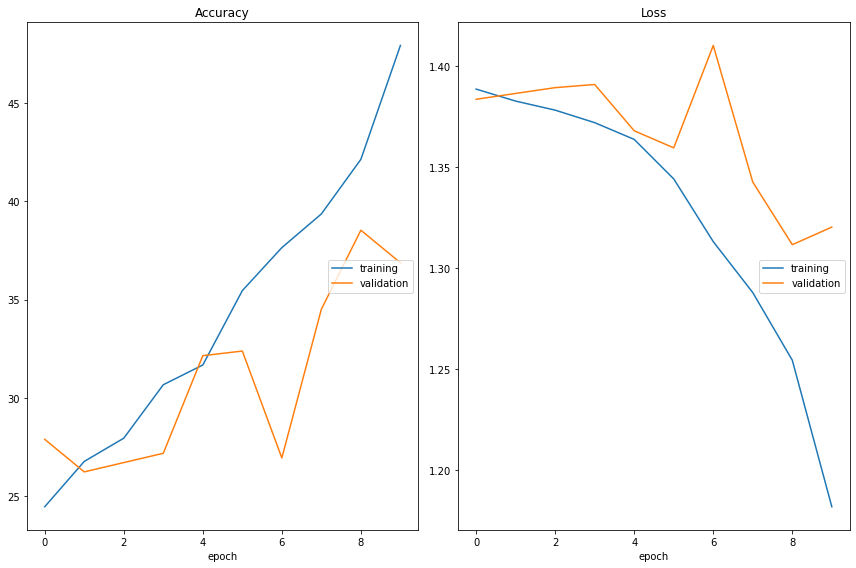

Accuracy
	training         	 (min:   24.468, max:   47.931, cur:   47.931)
	validation       	 (min:   26.241, max:   38.534, cur:   36.879)
Loss
	training         	 (min:    1.182, max:    1.389, cur:    1.182)
	validation       	 (min:    1.312, max:    1.410, cur:    1.320)


In [ ]:
#********************** TRAIN AND SAVE MODEL ******************************#
model=train_model(model, optimizer, num_epochs=10, dataloaders=dataloaders)

train CRNN model (modified)

In [ ]:
# define the hyperparamters
weight_decay = 0.001 # weight decay to alleviate overfiting

model = CRNN_v2(in_channels=1, classes=4).to(device)

count = count_parameters(model)
print ('model parameters amount {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=weight_decay)

NameError: ignored

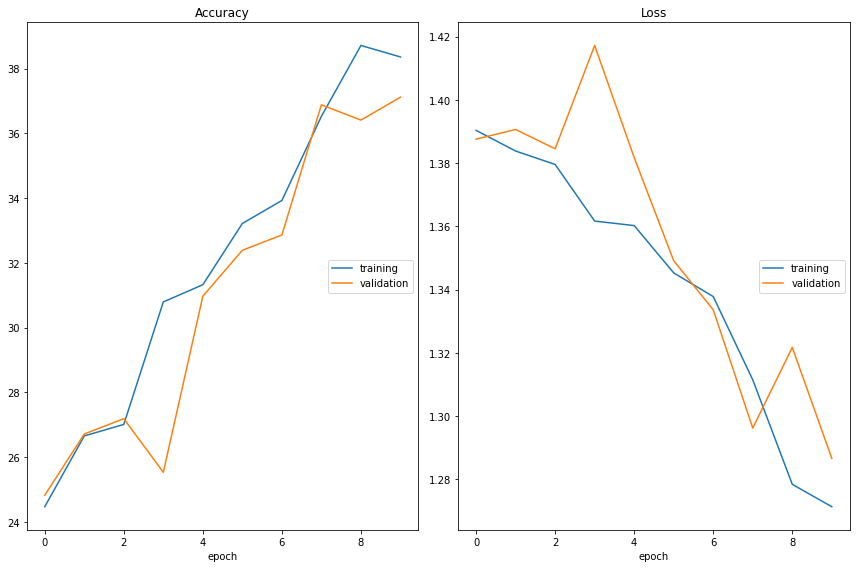

Accuracy
	training         	 (min:   24.468, max:   38.712, cur:   38.357)
	validation       	 (min:   24.823, max:   37.116, cur:   37.116)
Loss
	training         	 (min:    1.271, max:    1.390, cur:    1.271)
	validation       	 (min:    1.287, max:    1.417, cur:    1.287)


In [ ]:
#********************** TRAIN AND SAVE MODEL ******************************#
model=train_model(model, optimizer, num_epochs=10, dataloaders=dataloaders)

train CRNN with GRU

In [ ]:
# define the hyperparamters
weight_decay = 0.001 # weight decay to alleviate overfiting

model = CRNN_v4(in_channels=1, classes=4).to(device)

count = count_parameters(model)
print ('model parameters amount {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=weight_decay)

model parameters amount 566340


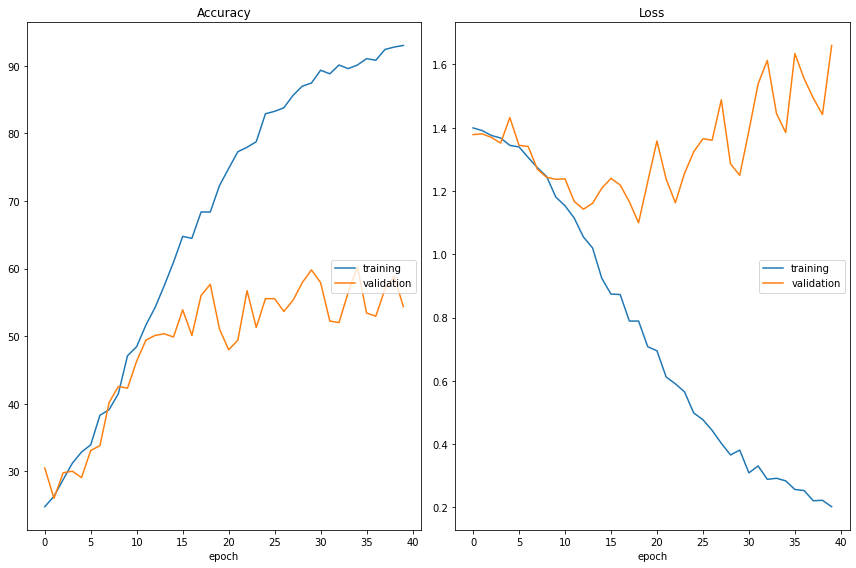

Accuracy
	training         	 (min:   24.764, max:   93.026, cur:   93.026)
	validation       	 (min:   26.005, max:   60.284, cur:   54.374)
Loss
	training         	 (min:    0.202, max:    1.399, cur:    0.202)
	validation       	 (min:    1.099, max:    1.660, cur:    1.660)


In [ ]:
#********************** TRAIN AND SAVE MODEL ******************************#
model=train_model(model, optimizer, num_epochs=40, dataloaders=dataloaders)

In [ ]:
test_result = test_model(model,test_data,loss_fn)

Test loss tensor(2.1358, device='cuda:0')
Test accuracy 54.85327313769752


train CRNN with 3 CNN + FC + GRU

In [ ]:
# define the hyperparamters
weight_decay = 0.001 # weight decay to alleviate overfiting

model2 = CRNN_v5(in_channels=1, classes=4).to(device)

count = count_parameters(model2)
print ('model parameters amount {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr = 1e-3, weight_decay=weight_decay)

model parameters amount 140244


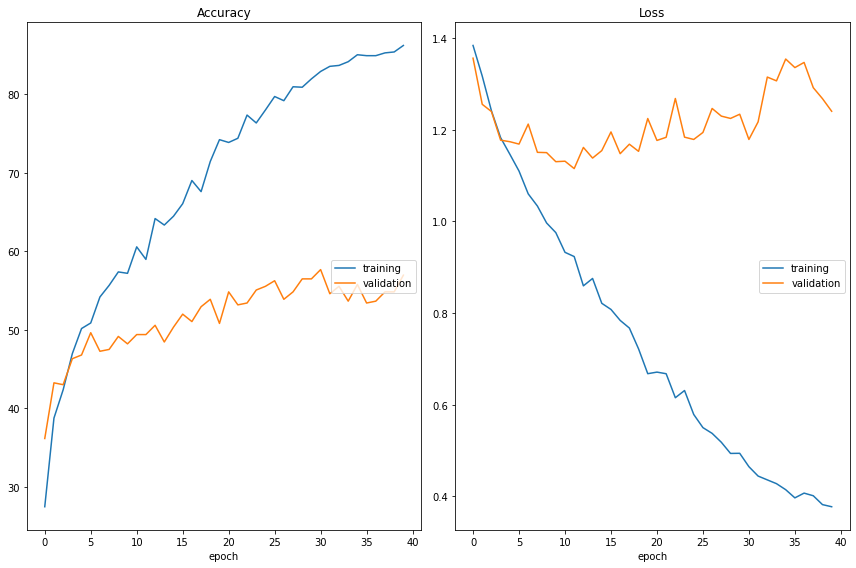

Accuracy
	training         	 (min:   27.482, max:   86.229, cur:   86.229)
	validation       	 (min:   36.170, max:   57.683, cur:   56.974)
Loss
	training         	 (min:    0.377, max:    1.384, cur:    0.377)
	validation       	 (min:    1.115, max:    1.356, cur:    1.240)


In [ ]:
#********************** TRAIN AND SAVE MODEL ******************************#
model2=train_model(model2, optimizer, num_epochs=40, dataloaders=dataloaders)

In [ ]:
test_result = test_model(model2,test_data,loss_fn)

Test loss tensor(4.3747, device='cuda:0')
Test accuracy 48.53273137697517


###new

In [ ]:
# define the hyperparamters
weight_decay = 0.008 # weight decay to alleviate overfiting

model3 = CRNN_v6(in_channels=1, classes=4).to(device)

count = count_parameters(model3)
print ('model parameters amount {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr = 1e-4, weight_decay=weight_decay)

model parameters amount 220196


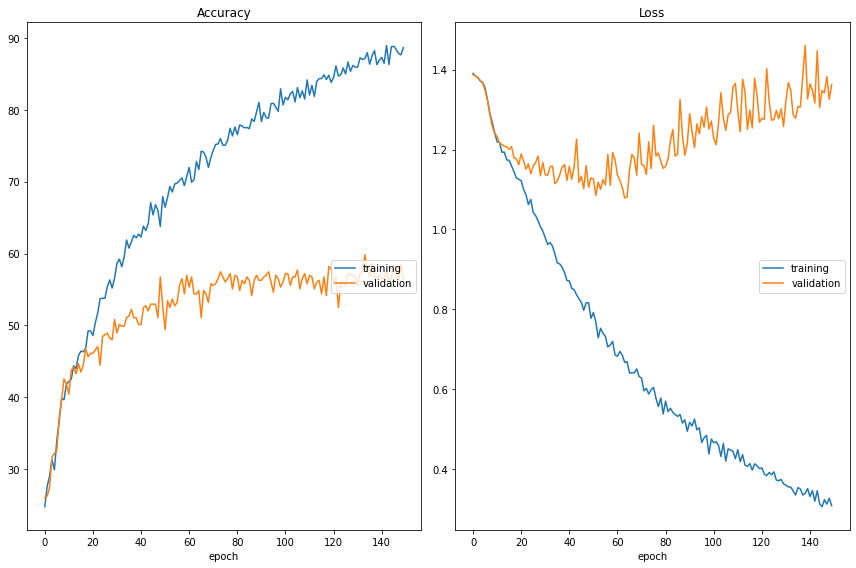

Accuracy
	training         	 (min:   24.764, max:   88.948, cur:   88.652)
	validation       	 (min:   26.005, max:   59.811, cur:   56.501)
Loss
	training         	 (min:    0.306, max:    1.390, cur:    0.309)
	validation       	 (min:    1.079, max:    1.461, cur:    1.363)


In [ ]:
#********************** TRAIN AND SAVE MODEL ******************************#
model3=train_model(model3, optimizer, num_epochs=150, dataloaders=dataloaders)

In [ ]:
test_result = test_model(model3,test_data,loss_fn)

Test loss tensor(0.2890, device='cuda:0')
Test accuracy 52.595936794582386


Train deep cnn

In [ ]:
# # define the hyperparamters
# weight_decay = 0.01 # weight decay to alleviate overfiting

# model = DeepCNN(in_channels=22, classes=4).to(device)

# count = count_parameters(model)
# print ('model parameters amount {}'.format(count))

# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=weight_decay)

model parameters amount 228429


In [ ]:
# #********************** TRAIN AND SAVE MODEL ******************************#
# model=train_model(model, optimizer, num_epochs=10, dataloaders=dataloaders)

Epoch 0/9
----------
LR 0.001


RuntimeError: ignored

## 4.7 evaluate Deep ConvNet

In [140]:
# define the hyperparamters
weight_decay = 0.15  # weight decay to alleviate overfiting

model = DeepConv(in_channels=1, classes=4).to(device)

count = count_parameters(model)
print ('model parameters amount {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)


model parameters amount 282504


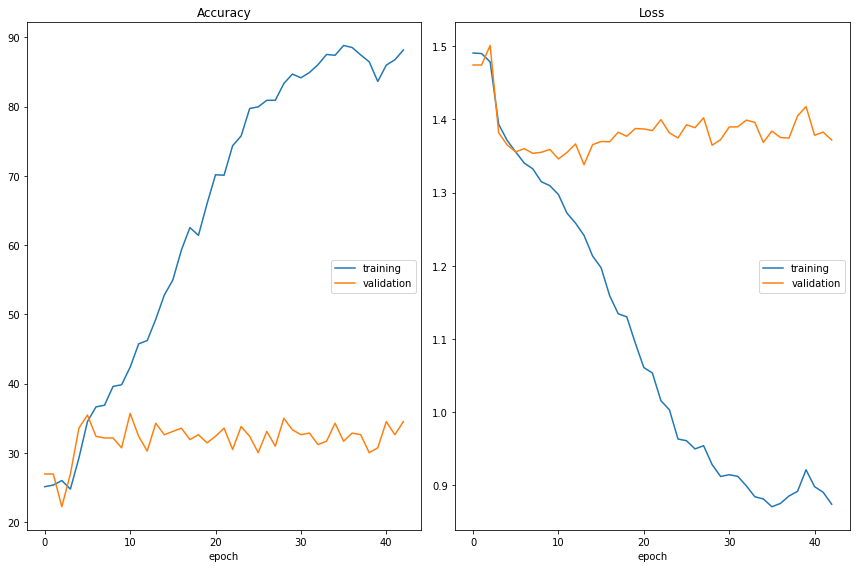

Accuracy
	training         	 (min:   24.764, max:   88.830, cur:   88.180)
	validation       	 (min:   22.222, max:   35.697, cur:   34.515)
Loss
	training         	 (min:    0.871, max:    1.491, cur:    0.874)
	validation       	 (min:    1.338, max:    1.501, cur:    1.372)
Epoch 43/249
----------
LR 0.0001


KeyboardInterrupt: ignored

In [141]:
model=train_model(model, optimizer, num_epochs=250, dataloaders=dataloaders)

#5. training with windowed data

In [ ]:
# Defining the parameters for model training

weight_decay = 0.15  # weight decay to alleviate overfiting
shallow_model = ShallowConv2(in_channels=1, num_conv_filters=40,num_samples_frame=num_samples_frame,num_eeg_channels=22,classes=4).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(shallow_model.parameters(), lr = 1e-4, weight_decay=weight_decay)

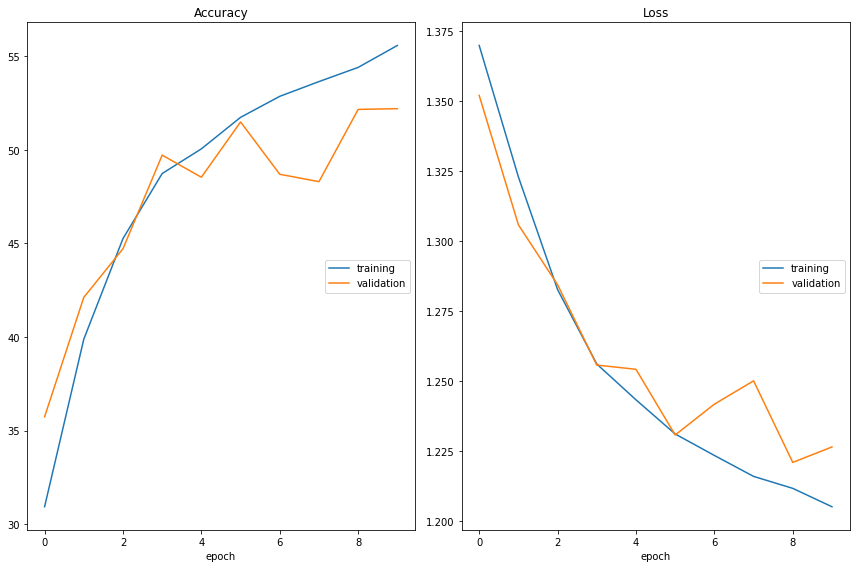

Accuracy
	training         	 (min:   30.930, max:   55.585, cur:   55.585)
	validation       	 (min:   35.737, max:   52.206, cur:   52.206)
Loss
	training         	 (min:    1.205, max:    1.370, cur:    1.205)
	validation       	 (min:    1.221, max:    1.352, cur:    1.226)


In [ ]:
# Training and validating the model

model=train_model(shallow_model, optimizer, num_epochs=10, dataloaders=win_dataloaders)

In [ ]:
test_a = test_model(shallow_model,test_win_data,loss_fn)

Test loss tensor(2.9285, device='cuda:0')
Test accuracy 46.3882618510158


#6. training with subject data

subject 1 with shallow CNN

In [ ]:
# define the hyperparamters
weight_decay = 0.15  # weight decay to alleviate overfiting

model = ShallowConv(in_channels=1, classes=4).to(device)

count = count_parameters(model)
print ('model parameters amount {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)

model parameters amount 46044


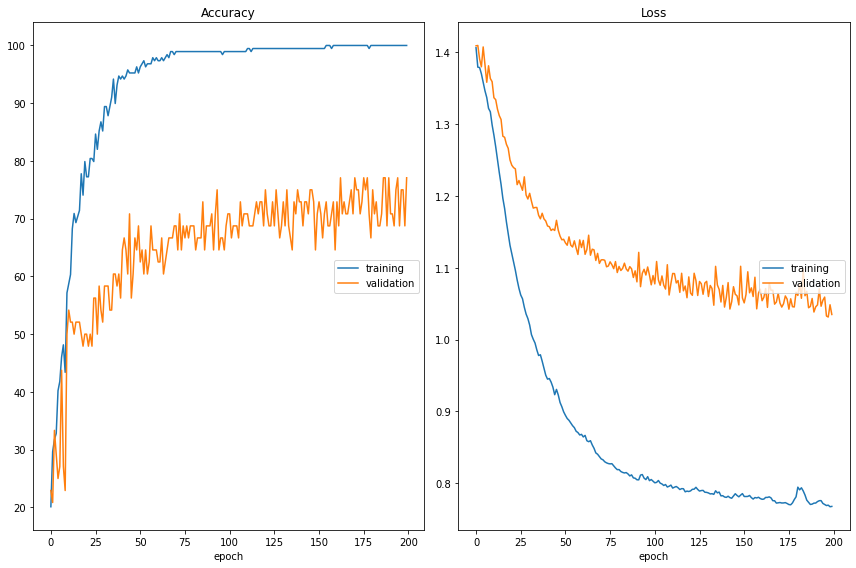

Accuracy
	training         	 (min:   20.106, max:  100.000, cur:  100.000)
	validation       	 (min:   20.833, max:   77.083, cur:   77.083)
Loss
	training         	 (min:    0.767, max:    1.406, cur:    0.768)
	validation       	 (min:    1.031, max:    1.409, cur:    1.035)


In [ ]:
#********************** TRAIN AND SAVE MODEL ******************************#
model=train_model(model, optimizer, num_epochs=200, dataloaders=dataloaders_subs[0])

In [ ]:
test_a = test_model(model,test_data_subs[0],loss_fn)

Test loss tensor(2.7333, device='cuda:0')
Test accuracy 72.0


subject 1 with CRNNv2

In [ ]:
# define the hyperparamters
weight_decay = 0.001 # weight decay to alleviate overfiting

model = CRNN_v2(in_channels=1, classes=4).to(device)

count = count_parameters(model)
print ('model parameters amount {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=weight_decay)

model parameters amount 716740


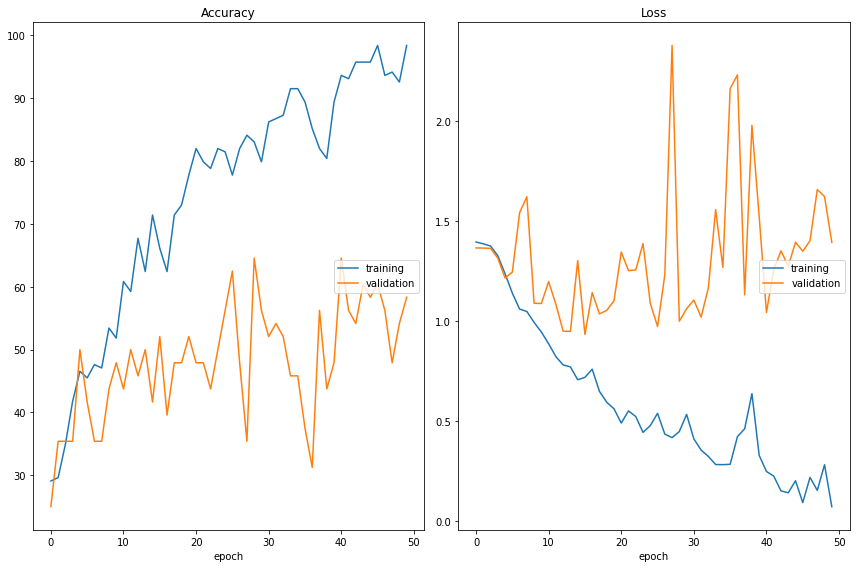

Accuracy
	training         	 (min:   29.101, max:   98.413, cur:   98.413)
	validation       	 (min:   25.000, max:   64.583, cur:   58.333)
Loss
	training         	 (min:    0.071, max:    1.396, cur:    0.071)
	validation       	 (min:    0.933, max:    2.380, cur:    1.394)


In [ ]:
#********************** TRAIN AND SAVE MODEL ******************************#
model=train_model(model, optimizer, num_epochs=50, dataloaders=dataloaders_subs[0])

In [ ]:
test_a = test_model(model,test_data_subs[0],loss_fn)

Test loss tensor(2.7159, device='cuda:0')
Test accuracy 56.00000000000001
